In [1]:
import numpy as np
from collections import defaultdict
import random
from tqdm import trange
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import igraph
from matplotlib import cm, colors
random.seed(42)
import seaborn as sns
from spatial_environments import * #ContinuousTMaze, GridEnvRightDownNoCue, GridEnvRightDownNoSelf, GridEnvDivergingMultipleReward, GridEnvDivergingSingleReward
from util import *
import itertools, random
# import numpy as np
# import matplotlib.pyplot as plt
from tqdm.auto import trange
# from util import transition_matrix_action

/Users/jungsun/opt/anaconda3/envs/cscg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


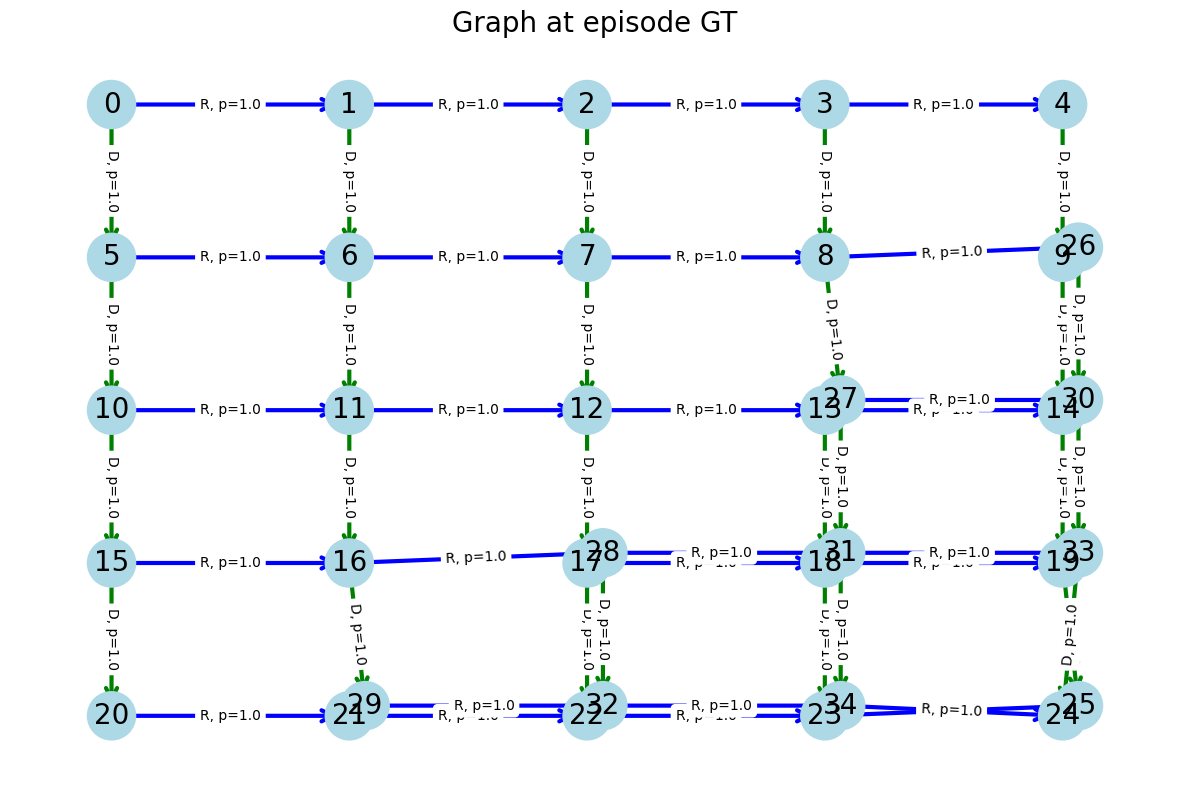

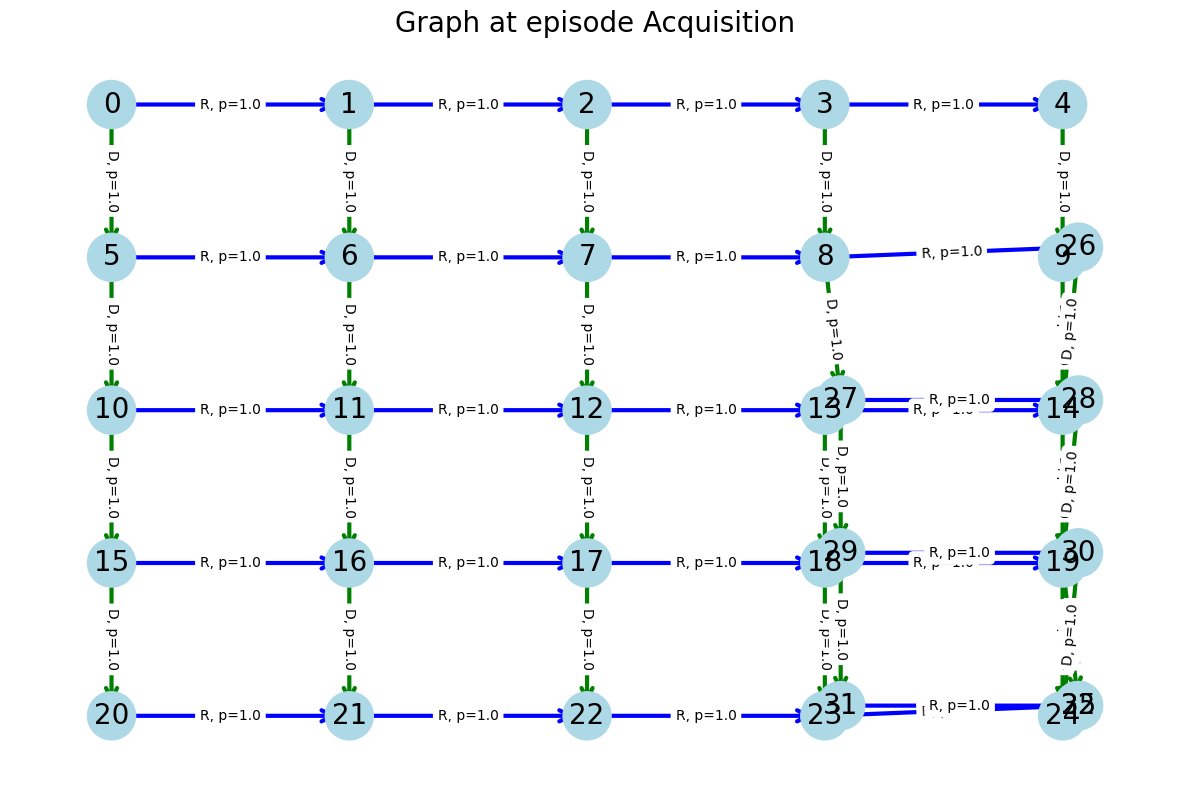

[  1   1 114]


ValueError: too many values to unpack (expected 2)

In [16]:
#!/usr/bin/env python
"""
CoDA evaluation – clone‑aware KL curve
=====================================
* Runs online CoDA learning under several random seeds.
* Computes KL divergence **after aligning clone indices** between the
  ground‑truth tensor (built offline) and the online tensor.
* Plots mean ± SE learning curve and prints the headline drop.

The script depends on all helper functions and classes used in your
original notebook (GridEnv*, generate_dataset, etc.).  Put this file in
the same folder or add that folder to PYTHONPATH.
"""

# ---------------------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from typing import Dict, Tuple, List

# ---------------------------------------------------------------------
# 1. Row‑normalisation helper
# ---------------------------------------------------------------------

def _renorm_rows(P: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Row-normalise each (state, action) categorical distribution.
    Safe for broadcast: P shape (S, A, S).
    """
    P = P.copy()
    row_sum = P.sum(axis=-1, keepdims=True)            # (S, A, 1)
    # Avoid division by zero: where sum==0 leave row unchanged (all zeros)
    P = np.divide(P, np.where(row_sum == 0, 1, row_sum), dtype=P.dtype)
    return P + eps

# ---------------------------------------------------------------------
# 2. Alignment utilities (keep clones separate)
# ---------------------------------------------------------------------

def build_alignment(
    env_ref,          # environment with GT tensor
    env_cmp,          # environment with online tensor
    grid_size: int    # e.g. 16 for 4×4 grid
) -> Tuple[Dict[int, int], Dict[int, int], int]:
    """Return two mapping dicts (ref→canon, cmp→canon) and canonical size."""
    # Identity for base grid states 0‥grid_size‑1
    ref2can = {s: s for s in range(grid_size)}
    cmp2can = {s: s for s in range(grid_size)}
    next_idx = grid_size

    # Gather *all* clones that exist in either env
    clones_ref = set(env_ref.clone_dict.keys())
    clones_cmp = set(env_cmp.clone_dict.keys())
    all_clones = sorted(clones_ref | clones_cmp)

    for c in all_clones:
        if c in ref2can or c in cmp2can:
            continue  # already assigned (shared clone id)
        ref2can[c] = next_idx
        cmp2can[c] = next_idx
        next_idx += 1

    return ref2can, cmp2can, next_idx  # S_canonical = next_idx


def project_tensor(P: np.ndarray, mapping: Dict[int, int], S_can: int) -> np.ndarray:
    """Re‑index rows/cols of *P* into canonical shape (S_can, A, S_can)."""
    S_src, A, _ = P.shape
    P_can = np.zeros((S_can, A, S_can), dtype=P.dtype)
    for s in range(S_src):
        if s not in mapping:
            continue
        row = mapping[s]
        for a in range(A):
            for sp in np.nonzero(P[s, a])[0]:
                if sp not in mapping:
                    continue
                col = mapping[sp]
                P_can[row, a, col] = P[s, a, sp]
    return P_can


def aligned_kl(
    P_true: np.ndarray,
    env_true,
    P_model: np.ndarray,
    env_model,
    grid_size: int,
    eps: float = 1e-12,
) -> float:
    """KL after aligning clone indices *without collapsing* clones."""
    ref2can, cmp2can, S_can = build_alignment(env_true, env_model, grid_size)

    Pt = _renorm_rows(project_tensor(P_true,  ref2can, S_can), eps)
    Pm = _renorm_rows(project_tensor(P_model, cmp2can, S_can), eps)

    kl = (Pt * np.log(Pt / Pm)).sum(axis=-1)  # shape (S_can, A)
    mask = Pt.sum(axis=-1) > 0               # rows with mass in GT
    return kl[mask].mean()

# ---------------------------------------------------------------------
# 3. Offline ground‑truth builder (unchanged logic, now returns env)
# ---------------------------------------------------------------------

# def latent_inhibition(
#     *,
#     seed: int,
#     size: int = 4,
#     n_episodes: int = 1000,
#     max_steps: int = 100,
#     iterations: int = 100,
#     cue = 5,
# ) -> Tuple[np.ndarray, 'GridEnvRightDownNoSelf']:
#     """Run the offline splitter to obtain fully expanded GT tensor."""
#     env_size = (size, size)
#     rewarded_terminal = [env_size[0]*env_size[1]-1]
#     cue_states = [cue]

#     env = GridEnvRightDownNoSelf(env_size=env_size,
#                                  rewarded_terminal=rewarded_terminal,
#                                  cue_states=cue_states,
#                                  seed=seed)

#     dataset = generate_dataset(env, n_episodes, max_steps)
    
#     extinction = [[[16 if x == 15 else x for x in idxs], labels]
#            for idxs, labels in dataset]
#     # dataset = extinction
    
    
    
#     transition_counts = transition_matrix_action(extinction_data)
#     denominators = transition_counts.sum(axis=2, keepdims=True)
#     denominators[denominators == 0] = 1
#     transition_probs = transition_counts / denominators

#     used_cues = []
#     for _ in range(iterations):
#         ent = compute_transition_entropies(transition_probs)
#         pairs = find_stochastic_state_actions_by_entropy(ent, eps=1e-9)
#         if not pairs:
#             break
#         cues_tmp = []
#         for s, a in pairs:
#             spr1, spr2 = get_successor_states(transition_counts, s, a)
#             cue = calculate_backward_contingency(dataset, spr1, spr2, env_size)
#             cues_tmp.append(cue)
#         unique_cues = np.unique([x for sub in cues_tmp for x in sub])
#         for cue in unique_cues:
#             if cue in used_cues:
#                 continue
#             used_cues.append(cue)
#             valid_actions = env.get_valid_actions(env.clone_dict.get(cue, cue))
#             for a in valid_actions:
#                 succ = get_successor_states(transition_counts, cue, a)[0]
#                 if succ in env.reverse_clone_dict:
#                     clone = env.reverse_clone_dict[succ]
#                 else:
#                     clone = len(get_unique_states(dataset))
#                     env.add_clone_dict(clone, succ)
#                     env.add_reverse_clone_dict(clone, succ)
#                 for d, seq in enumerate(dataset):
#                     if has_state(seq[0], succ) and has_transition(cue, succ, seq[0]):
#                         dataset[d][0] = [clone if x == succ else x for x in seq[0]]
#             # update counts
#             transition_counts = transition_matrix_action(dataset)
#             denominators = transition_counts.sum(axis=2, keepdims=True)
#             denominators[denominators == 0] = 1
#             transition_probs = transition_counts / denominators

#     return transition_probs, env

def build_ground_truth(
    *,
    seed: int,
    size: int = 4,
    n_episodes: int = 1000,
    max_steps: int = 100,
    iterations: int = 100,
    cue = 5,
) -> Tuple[np.ndarray, 'GridEnvRightDownNoSelf']:
    """Run the offline splitter to obtain fully expanded GT tensor."""
    env_size = (size, size)
    rewarded_terminal = [env_size[0]*env_size[1]-1]
    cue_states = cue

    env = GridEnvRightDownNoSelf(env_size=env_size,
                                 rewarded_terminal=rewarded_terminal,
                                 cue_states=cue_states,
                                 seed=seed)

    dataset = generate_dataset(env, n_episodes, max_steps)
    transition_counts = transition_matrix_action(dataset)
    denominators = transition_counts.sum(axis=2, keepdims=True)
    denominators[denominators == 0] = 1
    transition_probs = transition_counts / denominators

    used_cues = []
    for _ in range(iterations):
        ent = compute_transition_entropies(transition_probs)
        pairs = find_stochastic_state_actions_by_entropy(ent, eps=1e-9)
        if not pairs:
            break
        cues_tmp = []
        for s, a in pairs:
            spr1, spr2 = get_successor_states(transition_counts, s, a)
            cue = calculate_backward_contingency(dataset, spr1, spr2, env_size)
            cues_tmp.append(cue)
        unique_cues = np.unique([x for sub in cues_tmp for x in sub])
        for cue in unique_cues:
            if cue in used_cues:
                continue
            used_cues.append(cue)
            valid_actions = env.get_valid_actions(env.clone_dict.get(cue, cue))
            for a in valid_actions:
                succ = get_successor_states(transition_counts, cue, a)[0]
                if succ in env.reverse_clone_dict:
                    clone = env.reverse_clone_dict[succ]
                else:
                    clone = len(get_unique_states(dataset))
                    env.add_clone_dict(clone, succ)
                    env.add_reverse_clone_dict(clone, succ)
                for d, seq in enumerate(dataset):
                    if has_state(seq[0], succ) and has_transition(cue, succ, seq[0]):
                        dataset[d][0] = [clone if x == succ else x for x in seq[0]]
            # update counts
            transition_counts = transition_matrix_action(dataset)
            denominators = transition_counts.sum(axis=2, keepdims=True)
            denominators[denominators == 0] = 1
            transition_probs = transition_counts / denominators

    return transition_probs, env

# ---------------------------------------------------------------------
# 4. Plot helper (mean ± SE)
# ---------------------------------------------------------------------

def plot_kl_curve_se(kl_hist: np.ndarray, *, color="tab:blue"):
    n_runs, n_eps = kl_hist.shape
    mean = np.nanmean(kl_hist, axis=0)
    se   = np.nanstd(kl_hist, axis=0, ddof=1) / np.sqrt(n_runs)
    x = np.arange(1, n_eps+1)
    plt.figure(figsize=(7,4))
    plt.plot(x, mean, color=color, label=f"mean KL ({n_runs} seeds)")
    plt.fill_between(x, mean-se, mean+se, color=color, alpha=0.25, label="±1 SE")
    plt.xlabel("Episode"); plt.ylabel("KL (nats)")
    # plt.title("CoDA convergence – clone‑aligned KL")
    plt.title("Convergence of CoDA – KL (Cued reward)")
    plt.grid(alpha=0.3); plt.legend(frameon=False)
    plt.tight_layout()

# ---------------------------------------------------------------------
# 5.  Single‑seed online run
# ---------------------------------------------------------------------

def run_single_seed(cue: int, seed: int,  *, n_episodes: int = 1000, max_steps: int = 100, size: int = 4) -> List[float]:
    np.random.seed(seed)
    # size = 4
    env_size = (size, size)
    rewarded_terminal = [env_size[0]*env_size[1]-1]
    cue_states = [cue]
    # transition_probs, env = latent_inhibition(seed=seed, cue=cue)
    env = GridEnvRightDownNoSelf(env_size=env_size,
                                 rewarded_terminal=rewarded_terminal,
                                 cue_states=cue_states,
                                 seed=seed)

    episodes = generate_dataset(env, n_episodes, max_steps)
    
    blocking_env = GridEnvRightDownNoSelf(env_size=env_size,
                                 rewarded_terminal=rewarded_terminal,
                                 cue_states=[cue, 16],
                                 seed=seed)

    blocking_episodes = generate_dataset(blocking_env, n_episodes, max_steps)    
    
    n_states = max(max(pair[0]) for pair in episodes) + 1
    E_r = np.zeros((1, n_states)); E_nr = np.zeros_like(E_r); C = np.zeros_like(E_r)

    # ---- pre‑compute ground truth (tensor + env) -------------------
    P_true, env_gt = build_ground_truth(seed=seed, cue=[cue, 16], size=size)
    env_gt.plot_graph(P_true,'GT',savename='GT.png')
    grid_size = size * size

    kl_trace: List[float] = []
    used_cues: List[int] = []

    # LATENT INHIBITION
    # for e in range(200):
    for e in range(len(episodes)):    
        obs, _ = episodes[e]
        # obs[-1] = 16
        # transition counts online
        if e == 0:
            t_counts = transition_matrix_action_trial_by_trial(episodes, episodes[e])
        else:
            t_counts = transition_matrix_action_trial_by_trial(episodes, episodes[e], t_counts)

        ent, conf = compute_transition_entropies_thresholded(t_counts)
        pairs = find_stochastic_state_actions_by_entropy_thresholded(ent, conf, n_threshold=3)

        # ----------- (online splitting code: trimmed version) --------
        if pairs:
            cues_tmp = []
            for s,a in pairs:
                spr1, spr2 = get_successor_states(t_counts, s, a)
                E_r, E_nr, C = accumulate_conditioned_eligibility_traces(E_r, E_nr, C, obs, spr1, spr2,
                                                                         n_states, lam=0.8, gamma=0.9)
                cue = calculate_backward_contingency_trial_by_trial(E_r, E_nr, C, env_size, n_threshold=20)
                cues_tmp.append(cue)
            for cue in np.unique([x for sub in cues_tmp for x in sub]):
                if cue in used_cues:
                    continue
                used_cues.append(cue)
                valid_actions = env.get_valid_actions(env.clone_dict.get(cue, cue))
                for a in valid_actions:
                    succ = get_successor_states(t_counts, cue, a)[0]
                    if succ in env.reverse_clone_dict:
                        clone = env.reverse_clone_dict[succ]
                    else:
                        clone = len(get_unique_states(episodes))
                        env.add_clone_dict(clone, succ)
                        env.add_reverse_clone_dict(clone, succ)
                        for d, seq in enumerate(episodes):
                            if has_state(seq[0], succ) and has_transition(cue, succ, seq[0]):
                                episodes[d][0] = [clone if x == succ else x for x in seq[0]]
                                blocking_episodes[d][0] = [clone if x == succ else x for x in seq[0]]
                                
                        n_states += 1
                        C  = np.concatenate([C, np.zeros((1,1))], axis=1)
                        E_r = np.concatenate([E_r, np.zeros((1,1))], axis=1)
                        E_nr= np.concatenate([E_nr, np.zeros((1,1))], axis=1)
                t_counts = transition_matrix_action(episodes[:e+1])

        # ---- compute online tensor & KL -----------------------------
        denom = t_counts.sum(axis=2, keepdims=True); denom[denom==0] = 1
        P_model = t_counts / denom
        # kl = aligned_kl(P_true, env_gt, P_model, env, grid_size)
        # kl_trace.append(kl)
    # env.plot_graph(P_model,1, new_clone,savename=savename)
    env.plot_graph(P_model,'Acquisition',savename='pre_cr.png')  
    
    episodes = blocking_episodes
    for e in range(len(episodes)):
        obs, _ = episodes[e]
        # transition counts online
        # if e == 0:
            # t_counts = transition_matrix_action_trial_by_trial(episodes, episodes[e])
        # else:
        t_counts = transition_matrix_action_trial_by_trial(episodes, episodes[e], t_counts)

        ent, conf = compute_transition_entropies_thresholded(t_counts)
        pairs = find_stochastic_state_actions_by_entropy_thresholded(ent, conf, n_threshold=3)

        # ----------- (online splitting code: trimmed version) --------
        if pairs:
            cues_tmp = []
            for s,a in pairs:
                spr1, spr2 = get_successor_states(t_counts, s, a)
                E_r, E_nr, C = accumulate_conditioned_eligibility_traces(E_r, E_nr, C, obs, spr1, spr2,
                                                                         n_states, lam=0.8, gamma=0.9)
                cue = calculate_backward_contingency_trial_by_trial(E_r, E_nr, C, env_size, n_threshold=20)
                cues_tmp.append(cue)
            for cue in np.unique([x for sub in cues_tmp for x in sub]):
                if cue in used_cues:
                    continue
                used_cues.append(cue)
                valid_actions = env.get_valid_actions(env.clone_dict.get(cue, cue))
                for a in valid_actions:
                    succ = get_successor_states(t_counts, cue, a)[0]
                    if succ in env.reverse_clone_dict:
                        clone = env.reverse_clone_dict[succ]
                    else:
                        clone = len(get_unique_states(episodes))
                        env.add_clone_dict(clone, succ)
                        env.add_reverse_clone_dict(clone, succ)
                        for d, seq in enumerate(episodes):
                            if has_state(seq[0], succ) and has_transition(cue, succ, seq[0]):
                                episodes[d][0] = [clone if x == succ else x for x in seq[0]]
                        n_states += 1
                        C  = np.concatenate([C, np.zeros((1,1))], axis=1)
                        E_r = np.concatenate([E_r, np.zeros((1,1))], axis=1)
                        E_nr= np.concatenate([E_nr, np.zeros((1,1))], axis=1)
                t_counts = transition_matrix_action(episodes[:e+1])

        # ---- compute online tensor & KL -----------------------------
        denom = t_counts.sum(axis=2, keepdims=True); denom[denom==0] = 1
        P_model = t_counts / denom
        kl = aligned_kl(P_true, env_gt, P_model, env, grid_size)
        kl_trace.append(kl)
    env.plot_graph(P_model,'Cued reward',savename='post_cr.png')  
    return kl_trace

# ---------------------------------------------------------------------
# 6.  Main – run multiple seeds
# ---------------------------------------------------------------------

def main():
    seeds = np.arange(2)#np.arange(20) #[0, 1, 2, 3, 4]
    cues  = np.array([8])
    size=5

    # 1. build the full Cartesian product  → 20 pairs
    pairs = list(itertools.product(cues, seeds))   # (cue, seed)

    # 2. shuffle in-place for a random order
    random.shuffle(pairs)
    
    kl_mat = []
    for pair in pairs:
        # print(f"Seed {sd} …")
        cue = pair[0]
        sd = pair[1]
        kl_mat.append(run_single_seed(cue, sd, size=size))    
    # for sd in seeds:
    #     print(f"Seed {sd} …")
    #     kl_mat.append(run_single_seed(sd))

    # pad ragged to rectangular with NaNs
    max_len = max(len(v) for v in kl_mat)
    kl_padded = np.full((len(pairs), max_len), np.nan)
    for i, v in enumerate(kl_mat):
        kl_padded[i, :len(v)] = v

    plot_kl_curve_se(kl_padded)
    plt.savefig("kl_curve_cr.png", dpi=300)
    first = np.nanmean(kl_padded[:,0]); last = np.nanmean(kl_padded[:,-1])
    print(f"KL drops from {first:.3f} to {last:.3f} in {max_len} episodes (mean of {len(seeds)} seeds).  See kl_curve.png")


if __name__ == "__main__":
    main()


In [14]:
# P_true, env_gt = build_ground_truth(seed=seed, cue=[cue, 16], size=size)
env_gt.plot_graph(P_true,'GT',savename='pre_cr.png')  

NameError: name 'env_gt' is not defined

In [2]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [4]:
seeds = np.arange(20) #[0, 1, 2, 3, 4]
cues  = np.array([6])


# 1. build the full Cartesian product  → 20 pairs
pairs = list(itertools.product(cues, seeds))   # (cue, seed)
pairs

[(6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (6, 18),
 (6, 19)]